In [198]:
print "Each Type"
print "dataset : " , type(dataset)
print "label : " , type(dataset)
print "color_x : " , type(color_x)
print "gray_x : " , type(gray_x)
print "x : " , type(x)
print "x_train : " , type(x_train)
print "x_test : " , type(x_test)
print "y_train : " , type(y_train)
print "y_test : " , type(y_test)


print "Each Shape"
print "dataset : " , dataset.shape
print "label : " , label.shape
print "color_x : " , color_x.shape
print "gray_x : " , gray_x.shape
print "x : " , x.shape
print "x_train : " , x_train.shape
print "x_test : " , x_test.shape
print "y_train : " , y_train.shape
print "y_test : " , y_test.shape
#print y_train[0:8]
#draw_imgSet(color_x,4,4)

Each Type
dataset :  <type 'numpy.ndarray'>
label :  <type 'numpy.ndarray'>
color_x :  <type 'numpy.ndarray'>
gray_x :  <type 'numpy.ndarray'>
x :  <type 'numpy.ndarray'>
x_train :  <type 'numpy.ndarray'>
x_test :  <type 'numpy.ndarray'>
y_train :  <type 'numpy.ndarray'>
y_test :  <type 'numpy.ndarray'>
Each Shape
dataset :  (648, 1000, 500, 3)
label :  (392,)
color_x :  (648, 1000, 500, 3)
gray_x :  (648, 1000, 500)
x :  (648, 1, 1000, 500)
x_train :  (10, 1, 1000, 500)
x_test :  (40, 1, 1000, 500)
y_train :  (10,)
y_test :  (40,)


In [2]:
# coding:utf-8
%pylab inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from chainer import cuda, Variable, FunctionSet,\
     optimizers,Chain,serializers
import chainer.functions  as F
import sys

import time


import cv2

import os


#np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def to_plot(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def to_grayscale(img):
    grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayed
def blur(img):
    filtered = cv2.GaussianBlur(img, (11, 11), 0,0)
    return filtered
def threshold(img):
    th1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    return th1

In [4]:
def draw_img(img,title):
    img=img.astype(np.uint8)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.title(title,size=8)
    if len(img.shape)==3 :
        if img.shape[0]==1:
            h,w=img.shape[1:]
            img=img.reshape(h,w)
            draw_img(img)
        else:
            plt.imshow(to_plot(img))
    else:
        plt.gray()
        plt.imshow(img)
def draw_imgSet(imgset,labelset,cate,tate=1,yoko=3):
    plt.figure(figsize=(10,10))
    for idx in range(tate*yoko):
        img = imgset[idx]
        label = labelset[idx]
        title = cate[label]
        plt.subplot(tate, yoko, idx+1)
        draw_img(img,title)

In [5]:
def makeImgSet(N,FolderName,label):
    try :
        imgset = []
        img_list = os.listdir('./DataKeep/Picture/'+FolderName+'/')
        kakutyousi_list = []
    except OSError:
        print "\n\n"+FolderName+\
        "フォルダが見つからないよ!!!\n\n"
        raise
    #print img_list
    print FolderName,'フォルダ'
    val = 0
    for img_name in (img_list):
        kakutyousi = img_name.split(".")[1]
        if kakutyousi not in kakutyousi_list:
            kakutyousi_list.append(kakutyousi)
        if '.jpg' in img_name or '.jpeg' in img_name \
        or '.png' in img_name or '.JPG' in img_name:
            img =cv2.imread\
            ('./DataKeep/Picture/'+FolderName+'/'+img_name)
            #print "画像"+img_name+"を読み込みました"
            val+=1
            imgset.append(img)
        if val==N:
            break
    print "存在する拡張子:",kakutyousi_list
    print len(imgset),'枚画像読み込み完了！！\
    \n-------------------------------'
    label=np.zeros((len(imgset)))+label
    label = label.astype(np.int32)
    return imgset,label

def makeDataList(folder_list,N_array):
    class_num = len(folder_list)
    data_list = []
    label_list = []

    print "-------------------------------"
    for i in range(class_num):
        imgset , label = makeImgSet(N_array[i],folder_list[i], i)
        data_list.append(imgset)
        label_list.append(label)
    return data_list , label_list
def gattaiResize(data_list,label_list,h,w):
    class_num = len(data_list)
    c = 3
    sum_N = 0
    for i in range(class_num):
        N = len(data_list[i])
        sum_N+=N
        imgset=[0]*len(data_list[i])
        imgset[:]=data_list[i][:]
        label = label_list[i]
        for j in range(N):
            imgset[j]=cv2.resize(imgset[j],(w,h))
        imgset = np.array(imgset)
        if i== 0:
            dataset = imgset
            g_label = label
        elif i >= 1:
            dataset = np.vstack((dataset,imgset))
            g_label=np.hstack((g_label,label))

    dataset = dataset.astype(np.uint8)
    g_label = g_label.astype(np.int32)
    return dataset,g_label
def shuffle(dataset,g_label):
    N,h,w,c = dataset.shape

    s_dataset = np.zeros_like(dataset)
    s_dataset[:]=dataset[:]
    s_label = np.zeros_like(g_label)
    s_label[:]=g_label[:]

    s_dataset = s_dataset.reshape(N,h*w*c)
    if s_label.shape[0] != N:
        print "ラベルとdatasetのサイズが不一致"
    dataset_label = np.column_stack((s_dataset,s_label))
    np.random.shuffle(dataset_label)
    s_dataset = dataset_label[:,:h*w*c]
    s_label = dataset_label[:,h*w*c:]

    s_dataset = s_dataset.reshape(N,h,w,c)
    s_dataset = s_dataset.astype(np.uint8)

    s_label = s_label.ravel()
    s_label = s_label.astype(np.int32)
    return s_dataset,s_label
def preparColorGray(dataset):
    N,h,w = dataset.shape[0:3]
    #プロット用のカラー画像準備
    color_x = dataset
    #グレースケール画像準備
    gray_x=np.zeros((N,h,w))
    for i in range(N):
        gray_x[i]=cv2.cvtColor(color_x[i],cv2.COLOR_BGR2GRAY)
    gray_x = gray_x.astype(np.uint8)
    x=gray_x.reshape(N,1,h,w)
    #x  /= 255
    x=x.astype(np.float32)
    return color_x , gray_x , x
def TrainTestBunkatu(N,N_train,x,label):
    x_train, x_test , x_notUse = np.split(x, [N_train,N])
    y_train, y_test , y_notUse = np.split(label, [N_train,N])
    return x_train,x_test,y_train,y_test


In [8]:
folder_list=["Charhan","Gyouza"]
#folder_list=["Jikken"]

cate = ["Charhan","Gyouza"]

#何枚の画像を読み込むか(フォルダ内の画像数より大きいとフォルダ内の画像全てが読み込まれる)
N_array=np.zeros((len(folder_list)),dtype=np.int32)+36000
#何枚の画像をNNに突っ込むか
N = 36000
#読み込んだ画像全てをNNに入れる場合
#N=np.sum(N_array)
h = 500
w = 250
#トレーニングデータの数
N_train = 30000

In [9]:
data_list,label_list = makeDataList(folder_list,N_array)

-------------------------------
Charhan フォルダ
存在する拡張子: ['jpg', 'jpeg']
2 枚画像読み込み完了！！    
-------------------------------
Gyouza フォルダ
存在する拡張子: ['jpg']
2 枚画像読み込み完了！！    
-------------------------------


In [ ]:
dataset,g_label = gattaiResize(data_list,label_list,h,w)

In [ ]:
s_dataset,s_label = shuffle(dataset,g_label)

In [ ]:
color_x , gray_x , x = preparColorGray(s_dataset)

In [ ]:
x_train,x_test,y_train,y_test=TrainTestBunkatu(N,N_train,x,g_label)

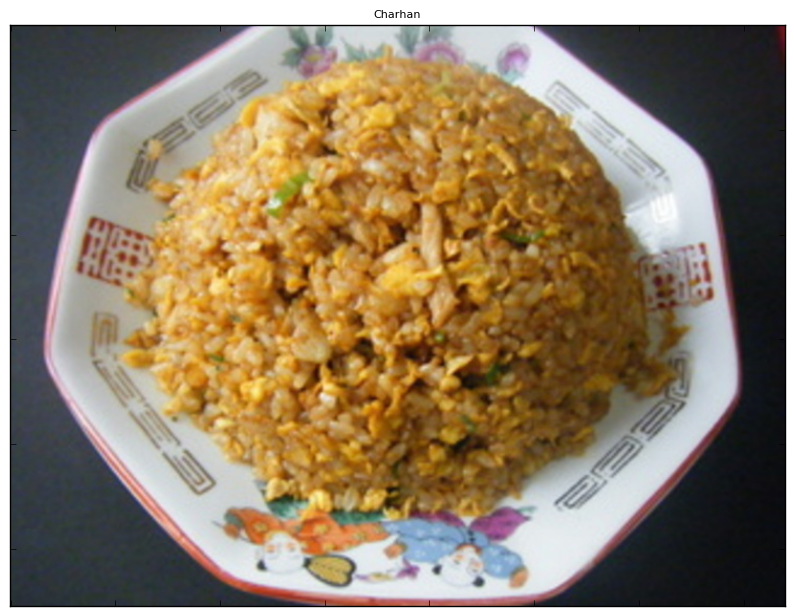

In [12]:
Charhan = data_list[0][0:1]
Charhan_label = label_list[0][0:1]

draw_imgSet(Charhan,Charhan_label,cate,1,1)

In [21]:
img = Charhan[0]
jikken_label=np.zeros((50000),dtype=np.int32)

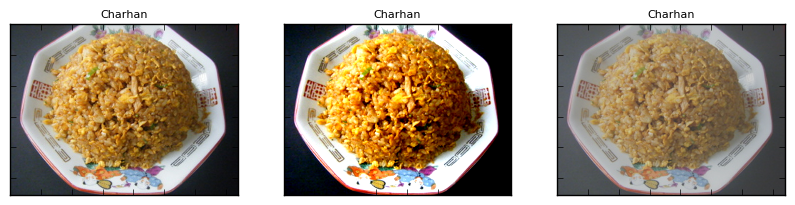

In [22]:
def contrast(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    # ルックアップテーブルの生成
    min_table = 50
    max_table = 205
    diff_table = max_table - min_table

    LUT_HC = np.arange(256, dtype = 'uint8' )
    LUT_LC = np.arange(256, dtype = 'uint8' )

    # ハイコントラストLUT作成
    for i in range(0, min_table):
        LUT_HC[i] = 0
    for i in range(min_table, max_table):
        LUT_HC[i] = 255 * (i - min_table) / diff_table
    for i in range(max_table, 255):
        LUT_HC[i] = 255

    # ローコントラストLUT作成
    for i in range(256):
        LUT_LC[i] = min_table + i * (diff_table) / 255

    # 変換
    high_cont_img = cv2.LUT(new_img, LUT_HC)
    low_cont_img = cv2.LUT(new_img, LUT_LC)
    
    high_cont_img = high_cont_img.astype(np.uint8)
    low_cont_img= low_cont_img.astype(np.uint8)
    return high_cont_img,low_cont_img

h_img , l_img = contrast(img)
jikken_imgset=[img , h_img , l_img]
draw_imgSet(jikken_imgset,jikken_label,cate,1,3)

In [23]:
def gamma(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    # ガンマ変換ルックアップテーブル
    gamma1 = 0.75
    gamma2 = 1.5
    
    LUT_G1 = np.arange(256, dtype = 'uint8' )
    LUT_G2 = np.arange(256, dtype = 'uint8' )
    
    for i in range(256):
        LUT_G1[i] = 255 * pow(float(i) / 255, 1.0 / gamma1)
        LUT_G2[i] = 255 * pow(float(i) / 255, 1.0 / gamma2)
    # 変換
    high_cont_img = cv2.LUT(new_img, LUT_G1)
    low_cont_img = cv2.LUT(new_img, LUT_G2)
    
    high_cont_img = high_cont_img.astype(np.uint8)
    low_cont_img= low_cont_img.astype(np.uint8)
    return high_cont_img,low_cont_img


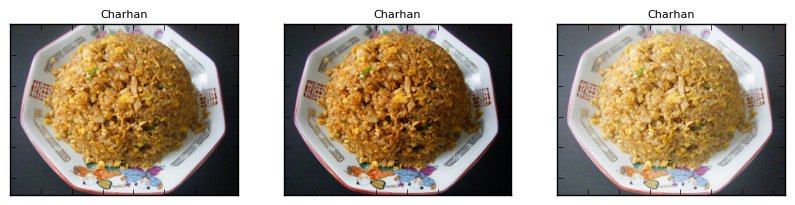

In [25]:
h_img2 , l_img2 = gamma(img)
jikken_imgset=[img , h_img2 , l_img2]
draw_imgSet(jikken_imgset,jikken_label,cate,1,3)

In [26]:
def blur(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    blured = cv2.blur(new_img, (10, 10))
    blured = blured.astype(np.uint8)
    return blured

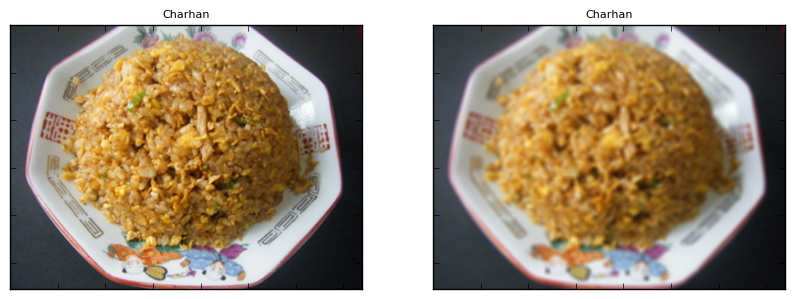

In [27]:
b_img =  blur(img)
jikken_imgset=[img , b_img]
draw_imgSet(jikken_imgset,jikken_label,cate,1,2)

In [28]:
def noise(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    row,col,ch= new_img.shape
    mean = 0
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    gauss_img = new_img + gauss
    gauss_img = gauss_img.astype(np.uint8)
    return gauss_img

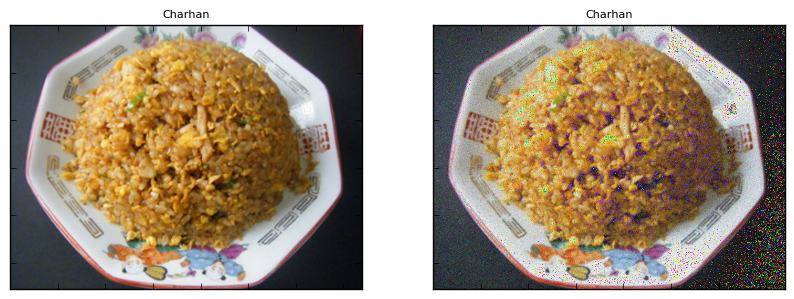

In [29]:
n_img =  noise(img)
jikken_imgset=[img , n_img]
draw_imgSet(jikken_imgset,jikken_label,cate,1,2)

In [30]:
def SPnoise(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    row,col,ch= new_img.shape
    
    s_vs_p = 0.5
    amount = 0.004
    sp_img = new_img.copy()

    # 塩モード
    num_salt = np.ceil(amount * new_img.size * s_vs_p)
    coords = [np.random.randint(0, i-1 , int(num_salt)) for i in new_img.shape]
    sp_img[coords[:-1]] = (255,255,255)

    # 胡椒モード
    num_pepper = np.ceil(amount* new_img.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i-1 , int(num_pepper)) for i in new_img.shape]
    sp_img[coords[:-1]] = (0,0,0)
    
    sp_img = sp_img.astype(np.uint8)
    return sp_img

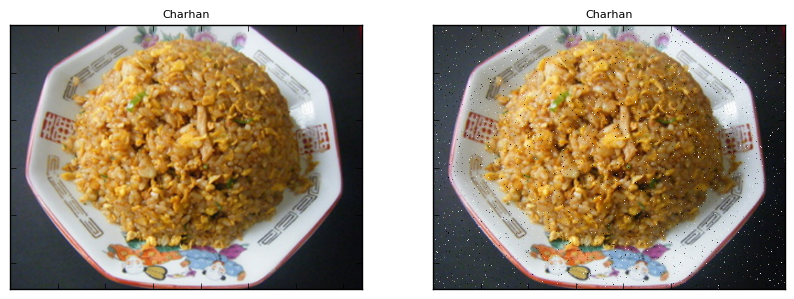

In [31]:
sp_img =  SPnoise(img)
jikken_imgset=[img , sp_img]
draw_imgSet(jikken_imgset,jikken_label,cate,1,2)


In [32]:
def Flip(img):
    new_img = np.zeros_like(img)
    new_img[:] = img[:]
    row,col,ch= new_img.shape
    hflip_img = cv2.flip(new_img, 1)
    vflip_img = cv2.flip(new_img, 0)
    return hflip_img,vflip_img

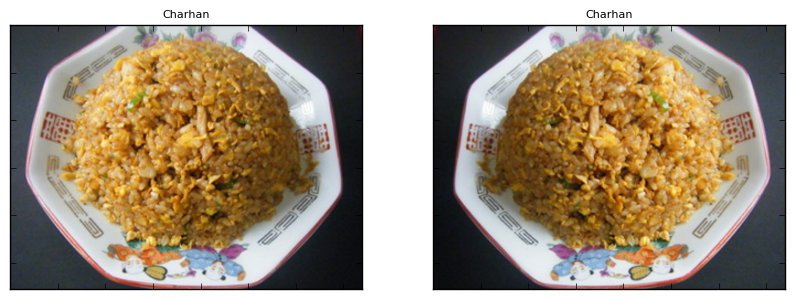

In [34]:
h_img , v_img=  Flip(img)
jikken_imgset=[img , h_img,v_img]
draw_imgSet(jikken_imgset,jikken_label,cate,1,2)

In [27]:
def Mizumasi(img):
    mizumasi = [img]
    f_img , vf_img=  Flip(mizumasi[0])
    mizumasi.append(f_img)
    #mizumasi.append(vf_img)

    repeat = len(mizumasi)
    for val in range(repeat):
        sp_img =  SPnoise(mizumasi[val])
        mizumasi.append(sp_img)


    repeat = len(mizumasi)
    for val in range(repeat):
        n_img =  noise(mizumasi[val])
        mizumasi.append(n_img)

    repeat = len(mizumasi)
    for val in range(repeat):
        b_img =  blur(mizumasi[val])
        mizumasi.append(b_img)

    repeat = len(mizumasi)
    for val in range(repeat):
        h_img , l_img = gamma(mizumasi[val])
        mizumasi.append(h_img)
        mizumasi.append(l_img)

    repeat = len(mizumasi)
    for val in range(repeat):
        h_img , l_img = contrast(mizumasi[val])
        mizumasi.append(h_img)
        mizumasi.append(l_img)

    return mizumasi

f = 0
for folder in folder_list:
    Hozonsaki = folder+'_mizumasi'
    if Hozonsaki not in os.listdir('./DataKeep/Picture/') :
        os.mkdir('./DataKeep/Picture/'+Hozonsaki)
    for img in data_list[f]:
        mizumasi = Mizumasi(img)
        for src in mizumasi:
            cv2.imwrite('./DataKeep/Picture/'+Hozonsaki+'/%s.jpg'%(str(time.clock()).replace('.','-',1)),src) 
    f+=1


In [26]:
print folder_list
print folder


['FatPerson', 'NotFatPerson']


NameError: name 'folder' is not defined

In [146]:
def Cut_img(img):
    Dir = "./haarcascadesWin/"
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_frontalface_default.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_eye.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_upperbody.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_lowerbody.xml')

    #drawed_img = img
    drawed_img = np.zeros_like(img)
    drawed_img[:] = img[:]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cascade = cv2.CascadeClassifier(Dir+'haarcascade_frontalface_default.xml')
    faces= cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3, minSize=(1, 1))
    
    if len(faces) > 0:
        print ("%d Faces Mituketa!!"%(len(faces)))
        for (x,y,w,h) in faces:
            
            #cv2.rectangle(drawed_img,(x,y),(x+w,y+h),(0,0,255),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = drawed_img[y:y+h, x:x+w]        
            draw_img(roi_color)      
            cv2.imwrite('./DataKeep/Picture/CutFace/CutFace%s.jpg'%(str(time.clock()).replace('.','-',1)),roi_color)
            
    else:
            print("No Faces!!!")
     
    cascade = cv2.CascadeClassifier(Dir+'haarcascade_fullbody.xml')
    bodys= cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3, minSize=(1, 1))
    if len(bodys) > 0:
        print ("%d Bodys Mituketa!!"%(len(bodys)))
        for (x,y,w,h) in bodys:
            
            
            #cv2.rectangle(drawed_img,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = drawed_img[y:y+h, x:x+w]
            cv2.imwrite('./DataKeep/Picture/CutBody/CutBody%s.jpg'%(str(time.clock()).replace('.','-',1)),roi_color)
    else:
            print("No Bodys!!!")
    
    return drawed_img
    


def Cut_imgSet(imgset,Cut_num):
    Cut_imgset = []
    i=0
    j=0
    
    for k in range(Cut_num):
        print "-----%d枚目の認識-----"%(k+1)
        Cut_imgset.append(Cut_img2(imgset[k]))
    return Cut_imgset

-----1枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----2枚目の認識-----
No Faces!!!
No Bodys!!!
-----3枚目の認識-----
No Faces!!!
No Bodys!!!
-----4枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----5枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----6枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----7枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----8枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----9枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----10枚目の認識-----
No Faces!!!
No Bodys!!!
-----11枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----12枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----13枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----14枚目の認識-----
No Faces!!!
No Bodys!!!
-----15枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----16枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----17枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----18枚目の認識-----
No Faces!!!
No Bodys!!!
-----19枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----20枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----21枚目の認識-----
1 Faces Mituketa!!
No Bodys!!!
-----22枚目の認識---

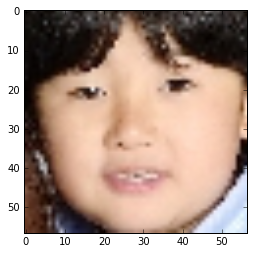

In [93]:
i=0
j=0
Cut_imgset = Cut_imgSet(data_list[0],len(data_list[0]))
Cut_imgset = Cut_imgSet(data_list[1],len(data_list[1]))
Cut_imgset = Cut_imgSet(data_list[2],len(data_list[2]))
#Cut_imgSet(data_list[1],len(data_list[1]))
#Cut_imgSet(data_list[2],len(data_list[2]))
#print data_list[2][1].sum()

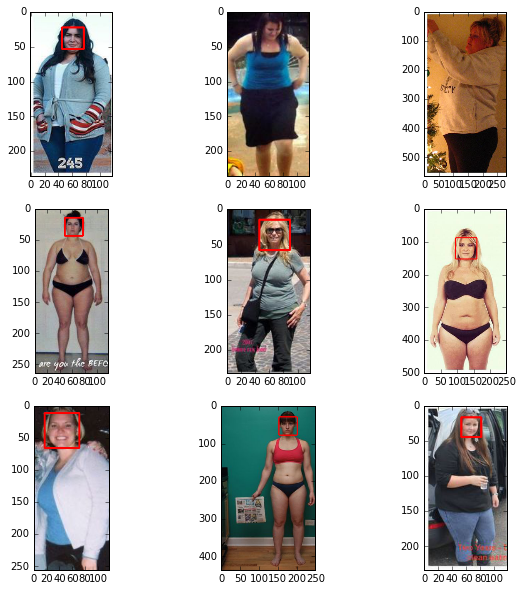

In [77]:
draw_imgSet(Cut_imgset,tate=3,yoko=3)

In [97]:
def img_Load2(N,Name):
    h = np.zeros((N))
    w = np.zeros((N))
    for i in range(N):
        img =cv2.imread\
        ('./DataKeep/Picture/'+Name+'/'+Name+'%d.jpg'%(i+1))
        img
        #print img.shape
        h[i]=img.shape[0]
        w[i]=img.shape[1]
    print "h : ",h.mean()
    print "w : ",w.mean()
    

In [98]:
img_Load2(188 , "After")

h :  341.271276596
w :  191.005319149


In [99]:
img_Load2(188 , "Before")

h :  341.271276596
w :  190.781914894


In [102]:
img_Load2(107 , "FatPerson")

h :  219.570093458
w :  239.018691589


In [104]:
img_Load2(106 , "NotFatPerson")

h :  249.103773585
w :  205.5


In [189]:
def padding_position(x, y, w, h):
    y1 = max(y-h , 0)
    x1 = max(x-2*w , 0)
    w1 = 3*w
    h1 =  13*h
    return x1 , y1 , w1 , h1

def Cut_img2(img):
    Dir = "./haarcascadesWin/"
    Hozonsaki = 'Cutjikken'
    if Hozonsaki not in os.listdir('./DataKeep/Picture/') :
        os.mkdir('./DataKeep/Picture/'+Hozonsaki)
    
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_frontalface_default.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_eye.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_upperbody.xml')
    #cascade = cv2.CascadeClassifier(Dir+'haarcascade_lowerbody.xml')

    #drawed_img = img
    drawed_img = np.zeros_like(img)
    drawed_img[:] = img[:]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cascade = cv2.CascadeClassifier(Dir+'haarcascade_frontalface_default.xml')
    faces= cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=3, minSize=(1, 1))
    
    print faces.shape
    
    if len(faces) > 0:
        
        bottom =  gray.shape[0]
        migihaji =  gray.shape[1]
        
        
        print ("%d Faces Mituketa!!"%(len(faces)))
        for (x,y,w,h) in faces:
            
            print gray.shape
            
            
            print x,y,w,h
            
            
            x1, y1, w1, h1 = padding_position(x, y, w, h)
            
            print x+w1
            
            x2 = min(migihaji,x+w1)
            y2 = bottom
            
            
            
            print x1,y1,x2,y2
            
            print 
            
            #cv2.rectangle(drawed_img,(x1,y1),(x2,y2),(0,0,255),2)
            roi_gray = gray[y1:y2, x1:x2]
            roi_color = drawed_img[y1:y2, x1:x2]
            
            
            #otherface=faces[val]
            #x,y,w,h = otherface
            #roi_color[y:y+h, x:x+w]=255
            
            
            #draw_img(roi_color)     
            cv2.imwrite('./DataKeep/Picture/'+Hozonsaki+'/%s.jpg'%(str(time.clock()).replace('.','-',1)),roi_color)        
    else:
            print("No Faces!!!")
     
    
    return drawed_img

#draw_img(data_list[2][7])
#print len(data_list[2])
#Cutimg  =  Cut_img2(data_list[0][0])
Cutimg  =  Cut_img2(data_list[0][7])
#Cut_imgset = Cut_imgSet(data_list[2],len(data_list[2]))
#draw_imgSet(data_list[2],tate=4,yoko=4)

(1, 4)
1 Faces Mituketa!!
(236, 118)
49 9 30 30
139
0 0 118 236

